In [4]:
#!/usr/bin/env python
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np, os, sys
from tqdm.notebook import tqdm    
from manipulations import get_Datas, segment_QRS, get_scored_class
from sklearn.model_selection import KFold, StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
N_CLASS = 27

In [119]:
MAX_RR = 500 # 60 beats/min => 60 beats/60 s ==> beat/1s ==> 500 samples / beat

In [10]:
Datas, Codes, dataset_train_idx, dataset_test_idx = get_Datas()

Dataset  1



Done.
Dataset  2


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  3


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  4


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  5


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.
Dataset  6


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.


In [16]:
from global_vars import labels, Dx_map, Dx_map_unscored, equivalent_mapping

In [391]:
datasets = [1, 2]
all_train_idx = []
for dataset in datasets:
    all_train_idx.extend(dataset_train_idx[dataset])
    
all_test_idx = []
for dataset in datasets:
    all_test_idx.extend(dataset_test_idx[dataset])

# Segmentation

In [392]:
from saved_data_io import read_file
Q_locs = read_file('Q_locs')

read from ../saved/newData_Q_locs_1000_7000_peakdist100.pkl


In [393]:
len(Codes)

43101

In [394]:
data_labels = np.array([get_scored_class(Codes[idx], labels) for idx in all_train_idx + all_test_idx])
print(data_labels.shape)

(10330, 27)


In [395]:
key_idxes = []
for key in equivalent_mapping.keys():
    print(key)
    key_idx = np.argwhere(labels==int(key)).flatten()[0]
    key_idxes.append(key_idx)
    val_idx = np.argwhere(labels==int(equivalent_mapping[key])).flatten()[0]
    key_pos = np.argwhere(data_labels[:,key_idx]==1).flatten()
    val_pos = np.argwhere(data_labels[:,val_idx]==1).flatten()
    data_labels[key_pos,val_idx] = 1
    data_labels[val_pos,key_idx] = 1

713427006
284470004
427172004


In [396]:
# non_empty_idx = np.argwhere(np.sum(data_labels, axis=1)!=0).flatten()
# empty_idx = np.argwhere(np.sum(data_labels, axis=1)==0).flatten()

In [397]:
X_train = []
Data_labels_train = []
Idxes_train = []
Idxes_dict_train = {}
ct = 0
for i in tqdm(all_train_idx):
    Q_loc = Q_locs[i]
    RR_avg = np.median([Q_loc[k+1] - Q_loc[k] for k in range(len(Q_loc)-1)])
    RR_th = (0.3 * RR_avg, 3 * RR_avg)
    
    ks = [k for k in range(len(Q_loc)-1) if Q_loc[k+1] - Q_loc[k] > RR_th[0] 
              and Q_loc[k+1] - Q_loc[k] < RR_th[1]]
    
    
    Idxes_dict_train[i] = []
    for k in ks:
        Data_labels_train.append(data_labels[i])
        X_train.append(Datas[i][:,Q_loc[k]:Q_loc[k+1]])
        Idxes_train.append(i)
        Idxes_dict_train[i].append(ct)
        
    ct += 1

/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [398]:
X_test = []
Data_labels_test = []
Idxes_test = []
Idxes_dict_test = {}
ct = 0
for i in tqdm(all_test_idx):
        
    Q_loc = Q_locs[i]
    RR_avg = np.median([Q_loc[k+1] - Q_loc[k] for k in range(len(Q_loc)-1)])
    RR_th = (0.3 * RR_avg, 3 * RR_avg)
    
    ks = [k for k in range(len(Q_loc)-1) if Q_loc[k+1] - Q_loc[k] > RR_th[0] 
              and Q_loc[k+1] - Q_loc[k] < RR_th[1]]
    
    
    Idxes_dict_test[i] = []
    for k in ks:
        Data_labels_test.append(data_labels[i])
        X_test.append(Datas[i][:,Q_loc[k]:Q_loc[k+1]])
        Idxes_test.append(i)
        Idxes_dict_test[i].append(ct)
        
    ct += 1

In [405]:
from sklearn.preprocessing import normalize
Signals_train = np.zeros((len(X_train),12,MAX_RR))
for i in range(len(X_train)):
    Signals_train[i,:,:min(len(X_train[i][0]),MAX_RR)] = normalize(X_train[i][:,:min(len(X_train[i][0]),MAX_RR)], axis=0)
    
    

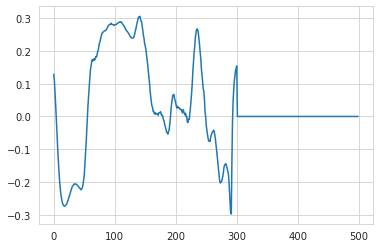

In [406]:
plt.plot(Signals_train[10][0])

In [407]:
from sklearn.preprocessing import normalize
Signals_test = np.zeros((len(X_test),12,MAX_RR))
for i in range(len(X_test)):
    Signals_test[i,:,:min(len(X_test[i][0]),MAX_RR)] = normalize(X_test[i][:,:min(len(X_test[i][0]),MAX_RR)], axis=0)
    

# On y va

In [434]:
run_name = 'ECGResNet_new_500RR_effectiveclass_12chn_normalized0_nosampler_batchsize64_dataset1+2'

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/{}'.format(run_name))


In [436]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [437]:
import torch
from torch import nn

In [438]:
class_idx = np.argwhere(np.sum(Data_labels_train,axis=0)!=0).flatten()

In [439]:
Signal_12leads_train = Signals_train
Signal_12leads_test= Signals_train 

In [440]:
Signal_12leads_train.shape

(97615, 12, 500)

In [441]:
from torch.utils.data import Dataset
from torchvision import transforms

import os
class SignalDataset(Dataset):

    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample =(torch.cat([torch.Tensor(np.array([self.signals[idx,channel]])) for channel in range(12)], axis=0), 
                  torch.Tensor(self.labels[idx]))

        return sample
    
signal_datasets_train = SignalDataset(Signal_12leads_train[:,:,:MAX_RR], np.array(Data_labels_train)[:,class_idx])
signal_datasets_test = SignalDataset(Signal_12leads_test[:,:,:MAX_RR], np.array(Data_labels_test)[:,class_idx])


In [442]:
assert len(signal_datasets_train[0][1]) == len(class_idx)

In [443]:
signal_datasets_train[0][0].shape

torch.Size([12, 500])

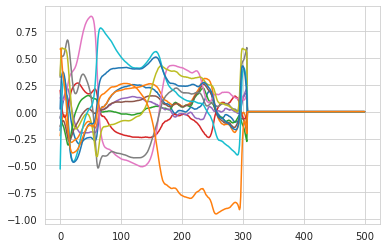

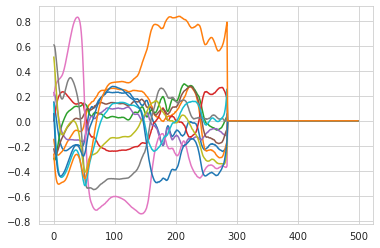

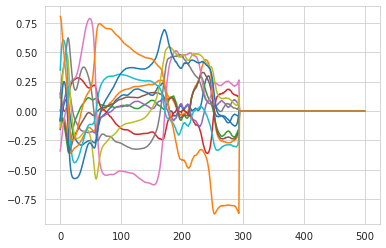

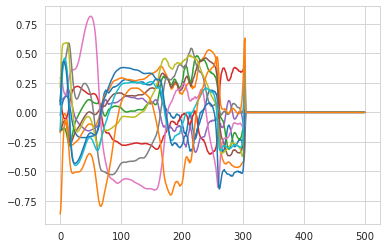

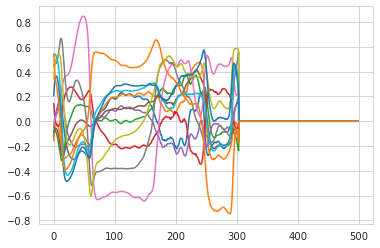

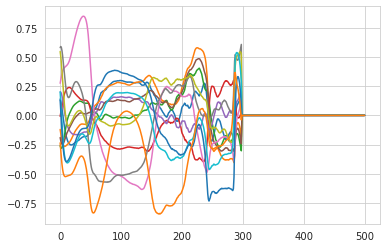

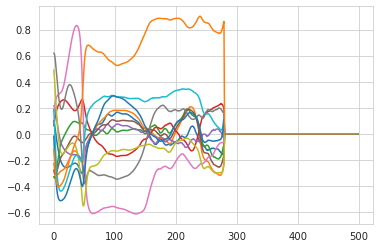

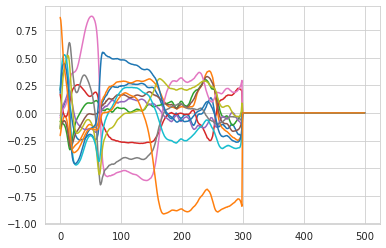

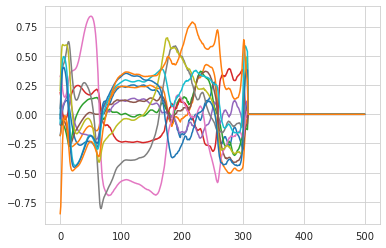

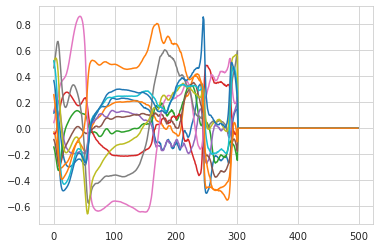

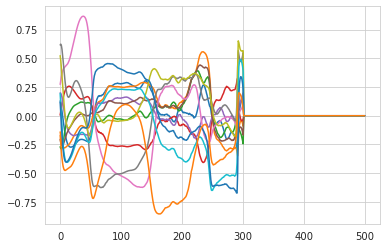

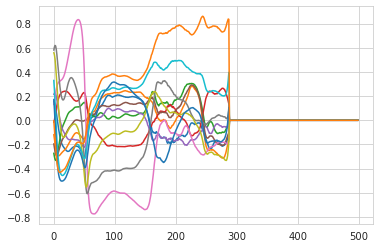

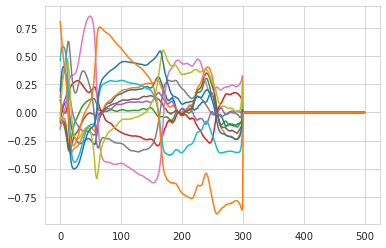

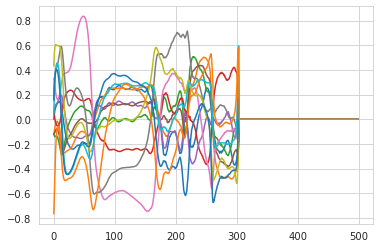

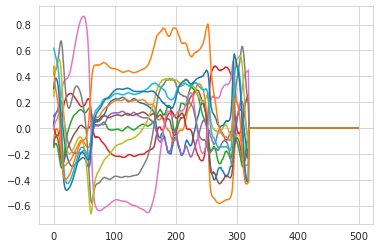

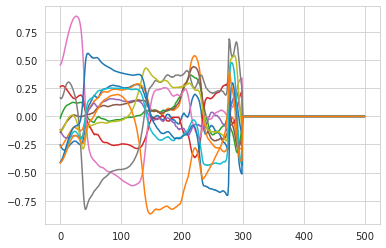

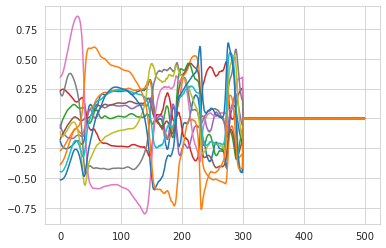

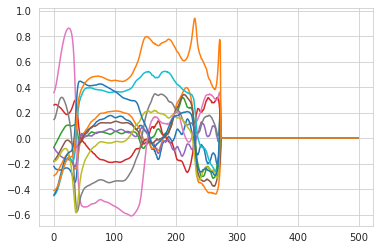

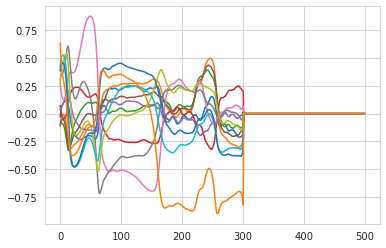

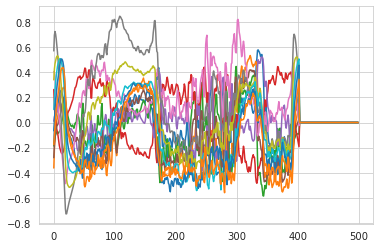

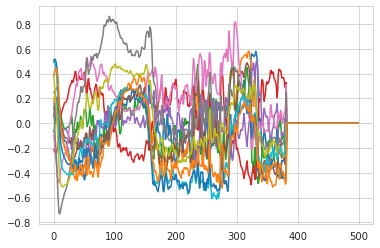

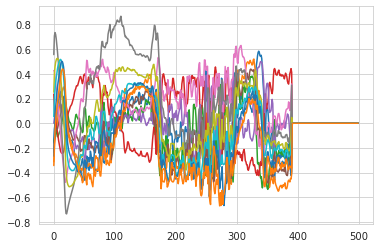

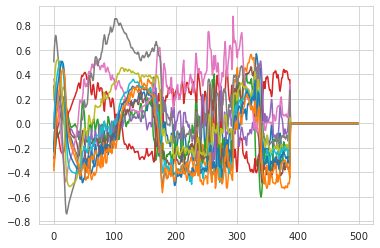

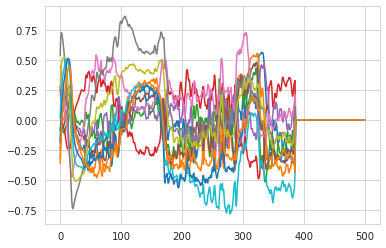

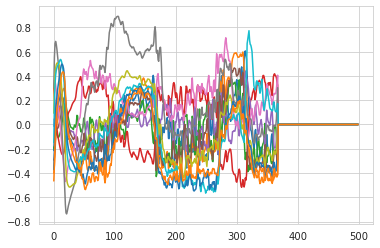

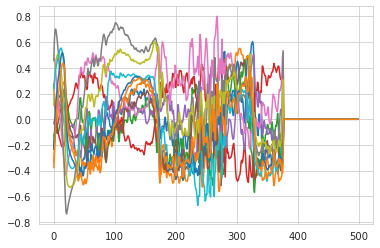

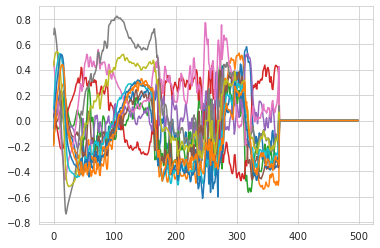

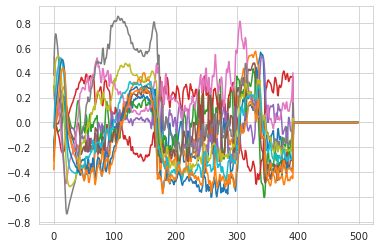

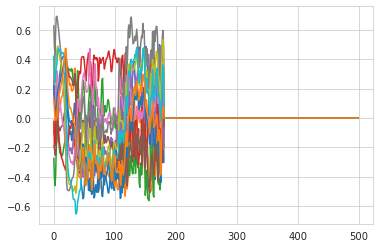

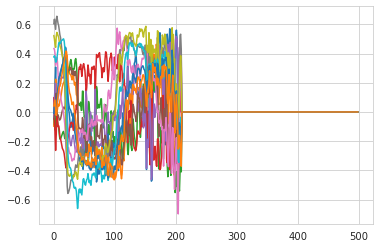

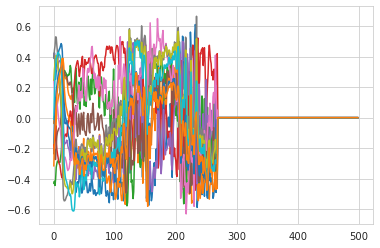

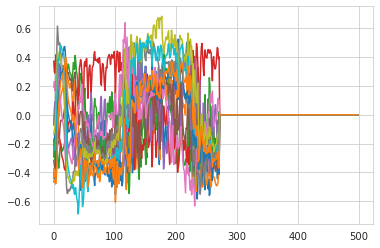

In [444]:
for idx in range(32):
    [plt.plot(signal_datasets_train[idx][0][i]) for i in range(12)] 
    plt.show()

In [446]:
weights_tensor = torch.Tensor(weights).to(device)

In [448]:
import torch
dummy = torch.ones((10, 12, MAX_RR))
dummy2 = torch.ones((10, MAX_RR, 12))

In [449]:
from resnet1d import ECGResNet
model = ECGResNet(12, len(class_idx), n=1)

In [450]:
#model(dummy).shape

torch.Size([10, 22])

In [451]:
from torchvision import datasets, models, transforms
from myeval import agg_y_preds_bags, binary_acc, geometry_loss, compute_score
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
import time
from pytorch_training import add_pr_curve_tensorboard

st = time.time()
patience = 50
batch_size= 64#65000

saved_dir = '../saved/ECGResNet/'
model.to(device)



from imbalanced_weights import cal_multilabel_weights, inverse_weight
sample_weights, Data_labels_train_new, label_to_count, new_index_dict= cal_multilabel_weights(Data_labels_train, 0)

from imbalanced_sampler import  WeightedImbalancedDatasetSampler
trainDataset = torch.utils.data.Subset(signal_datasets_train, range(0,len(Signals_train), 1))
testDataset = torch.utils.data.Subset(signal_datasets_test, range(0,len(Signals_test), 1))

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, pin_memory=True, shuffle=True)
                                     #  sampler=WeightedImbalancedDatasetSampler(trainDataset, weights=sample_weights))
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=3000, shuffle = False, pin_memory=True)

train_class_weight = torch.Tensor(inverse_weight(Data_labels_train, class_idx)).to(device)
test_class_weight = torch.Tensor(inverse_weight(Data_labels_test, class_idx)).to(device)
criterion_train = nn.BCEWithLogitsLoss(reduction='mean')#, weight=train_class_weight) 
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')#, weight=test_class_weight) 

early_stopping = EarlyStopping(patience, verbose=False, 
                              saved_dir=saved_dir, 
                              save_name=run_name)

optimizer = optim.Adam(model.parameters(), lr=0.01) 
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
# Decay LR by a factor of 0.1 every 100 epochs
#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20, mode='max')

names = [get_name(label, Dx_map, Dx_map_unscored) for label in labels]
names = np.array(names)[class_idx]
from global_vars import normal_class
normal_idx = np.argwhere(names==int(normal_class))

y_trains_tensor = None
y_tests_tensor = None
losses_train = []
avg_losses_train = []
losses_test = []
avg_losses_test = []
for epoch in range(0, 5000):

    model.train()

    running_loss_train = 0.0

    y_trains = [] # ground truth
    output_trains = [] # output
    for k, (X_train, y_train) in tqdm(enumerate(trainLoader)):
        y_train = y_train.to(device)
        X_train = X_train.to(device)
        optimizer.zero_grad()
        output_train = model(X_train)
        output_trains.append(output_train.cpu())
        
        loss_train = criterion_train(output_train, y_train)
        losses_train.append(loss_train.item())
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
    
        
        if np.mod(k, 100) == 0:
            writer.add_scalar('train/loss',
            avg_loss_train,
            epoch * (len(Data_labels_train)//batch_size//100+1) + k//100)
        
        y_trains.append(y_train.cpu())
            
        loss_train.backward()
        optimizer.step()
            
    #scheduler.step()
    

    y_tests = [] # ground truth
    output_tests = [] # output
    with torch.no_grad():
        model.eval()
        
        for X_test, y_test in testLoader:  
            y_test = y_test.to(device)
            X_test = X_test.to(device)
            output_test = model(X_test)

            loss_test = criterion_test(output_test, y_test)
            losses_test.append(loss_test.item())

            output_tests.append(output_test.cpu())
            y_tests.append(y_test.cpu())
            
            
            
        avg_loss_test = np.average(losses_test)
        avg_losses_test.append(avg_loss_test)

        writer.add_scalar('test/loss',
                avg_loss_test,
                epoch)



    y_trains_tensor = torch.cat(y_trains, axis=0) # ground truth
    y_tests_tensor = torch.cat(y_tests, axis=0) # ground truth

    output_trains = torch.cat(output_trains, axis=0) 
    y_train_preds = torch.sigmoid(output_trains)

    output_tests = torch.cat(output_tests, axis=0)
    y_test_preds = torch.sigmoid(output_tests)

    #output_trains = torch.cat(output_trains, axis=0)
#     y_train_preds_max, y_train_preds_mean, _ = agg_y_preds_bags(y_train_preds, bag_size=n_segments)
#     y_test_preds_max, y_test_preds_mean, _ = agg_y_preds_bags(y_test_preds, bag_size=n_segments)
#     _, _, y_trains = agg_y_preds_bags(y_trains, bag_size=n_segments)
#     _, _, y_tests = agg_y_preds_bags(y_tests, bag_size=n_segments)


    for class_i_idx in range(len(class_idx)):
        add_pr_curve_tensorboard(writer, class_i_idx, y_trains_tensor, y_train_preds, names, global_step=epoch, prefix='train/')
        add_pr_curve_tensorboard(writer, class_i_idx, y_tests_tensor, y_test_preds, names, global_step=epoch, prefix='test/')



    acc, fmeasure, fbeta, gbeta = binary_acc(y_train_preds, y_trains_tensor)           
    acc2, fmeasure2, fbeta2, gbeta2 = binary_acc(y_test_preds, y_tests_tensor)
    geometry = geometry_loss(fbeta, gbeta)
    geometry2 = geometry_loss(fbeta2, gbeta2)
    
#     output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
#         epoch, (time.time()-st)/60,
#         avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, np.nan,
#         avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, np.nan)
#     print(output_str)
    score = compute_score(np.round(y_train_preds.data.numpy()), np.round(y_trains_tensor.data.numpy()),  weights, class_idx, normal_idx)
    score2 = compute_score(np.round(y_test_preds.data.numpy()), np.round(y_tests_tensor.data.numpy()), weights, class_idx, normal_idx)
    output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
        epoch, (time.time()-st)/60,
        avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, score,
        avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, score2)
    scheduler.step(score2)
    
    writer.add_scalar('train/score',
            score,
            epoch)

    writer.add_scalar('test/score',
            score2,
            epoch)
    
    print(output_str)

    with open(saved_dir+'loss_{}.txt'.format(run_name), 'a') as f:
        print(output_str, file=f)

    early_stopping(-score2, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


#     output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure|Geomotry\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2,geometry2)
#     print(output_string)     
#     with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
#         f.write(output_string)

#     avg_losses_train = np.array(avg_losses_train)
#     avg_losses_test = np.array(avg_losses_test)

#     np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
#     np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)


ECGResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNet753Block(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv1dAuto(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv1dAuto(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from global_vars import labels

cf_matrices = multilabel_confusion_matrix(y_trains_tensor.data.numpy(), np.round(y_train_preds.data.numpy()))

In [ ]:
for label, cf_matrix in zip(labels, cf_matrices):
    print(get_name(label, Dx_map, Dx_map_unscored))
    print(cf_matrix)
    print('\n')


In [ ]:
y_trains_tensor.data.numpy()